In [ ]:
num_filters = 32
kernel_size = 4
epochs = 64
batch_size = 16

In [ ]:
from osgeo import gdal
import numpy as np
import os
import pandas as pd
import datetime
import warnings
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter("ignore")

In [ ]:
# df = pd.read_parquet("/kaggle/input/aws-merged-full")
!pip install -q gdown
!gdown 115b2vVHryiPFOPYRumGBDIpx5dT_vH7R
df = pd.read_parquet("/kaggle/working/aws_rainfall_all.parquet")

In [ ]:
col = np.array(df["Col"].unique())
row = np.array(df["Row"].unique())
print(np.min(row), np.max(row))
print(np.min(col), np.max(col))


0 87
55 167


In [ ]:
def compact_map_column(df, col_name):
    unique_sorted = np.sort(df[col_name].unique())
    mapping = {val: idx for idx, val in enumerate(unique_sorted)}
    df[col_name + "_mapped"] = df[col_name].map(mapping)
    return mapping

# Apply to both row and col
row_map = compact_map_column(df, "Row")
col_map = compact_map_column(df, "Col")


In [ ]:
df.head(5)

,Datetime,Row,Col,aws_rainfall,era5_r850,era5_slor,era5_r250,era5_sshf,era5_kx,era5_tcw,...,era5_v250,era5_cape,era5_tclw,era5_isor,era5_ie,era5_r500,era5_cin,era5_u250,Row_mapped,Col_mapped
0,2019-04-01,24,106,0.0,96.768906,0.031116,13.146707,-38970.0,36.147285,44.220032,...,5.449234,454.875,0.484680,0.639833,-0.000010,25.537670,11.765632,27.098175,24,33
1,2019-04-01,76,116,0.0,75.671249,0.033132,18.002174,-5498.0,26.215645,34.761047,...,4.859390,1021.625,0.201050,0.518284,-0.000013,18.740795,24.015633,19.537628,73,43
2,2019-04-01,3,150,0.0,84.491562,0.009856,40.154518,16198.0,32.049629,46.362610,...,4.847672,327.250,0.181274,0.540271,-0.000032,47.318920,222.125000,27.490753,3,73
3,2019-04-01,76,134,0.0,75.546249,0.003868,14.244363,-3194.0,21.821114,43.241516,...,4.632828,1183.625,0.118225,0.109765,-0.000009,18.916576,23.140633,17.672394,73,61
4,2019-04-01,26,124,0.0,92.917343,0.003368,12.482644,-3258.0,33.186348,47.550110,...,4.429703,648.500,0.489319,0.297861,-0.000017,38.279858,49.875008,27.107941,26,51


In [ ]:
def create_time_series_data(rainfall, timestamps, past_steps=12, future_steps=3, samples_per_day=24):
    total_steps = past_steps + future_steps
    step_size = int(24 / samples_per_day)

    X_data, y_data, positions = [], [], []

    for i in range(0, len(rainfall) - total_steps + 1, step_size):
        if len(rainfall[i:i + total_steps]) == total_steps:
            X_data.append(np.array(rainfall[i:i + past_steps]))
            y_data.append(np.array(rainfall[i + past_steps:i + total_steps]))
            positions.append(timestamps[i + total_steps - 1])

    return np.array(X_data), np.array(y_data), np.array(positions)

def calculate_optimum_alpha(data):
    X_max = np.max(data)
    X_min = np.min(data)
    X_mean = np.mean(data)
    return ((X_max - X_min) - X_mean) / (X_max - X_min) if (X_max - X_min) != 0 else 0.5

def exponential_smoothing(data, alpha = 0.2):
    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

def data_smoothing(df):
    feature_cols = [col for col in df.columns if col not in ["Row", "Col", "Datetime", "aws_rainfall", "smoothed_rainfall", "Row_mapped", "Col_mapped",]]

    for (row, col), group in tqdm(df.groupby(["Row", "Col"]), desc="Processing groups", unit="group"):
        group = group.sort_values("Datetime")
        original_rainfall_values = group['aws_rainfall'].values
        alpha = calculate_optimum_alpha(original_rainfall_values)
        rainfall_values = exponential_smoothing(original_rainfall_values, alpha)

        # Update smoothed rainfall values back to the DataFrame
        df.loc[group.index, 'smoothed_rainfall'] = rainfall_values

    return df

In [ ]:
col = np.array(df["Col_mapped"].unique())
row = np.array(df["Row_mapped"].unique())
print(np.min(row), np.max(row))
print(np.min(col), np.max(col))


0 82
0 77


In [ ]:
df.replace([9999, np.inf, -np.inf], 0, inplace=True)
df = data_smoothing(df)
df["Col"] = df["Col_mapped"]
df["Row"] = df["Row_mapped"]
df.drop(["Col_mapped", "Row_mapped"], axis = 1, inplace = True)

Processing groups: 100%|██████████| 334/334 [00:03<00:00, 101.39group/s]


In [ ]:
df.head()

,Datetime,Row,Col,aws_rainfall,era5_r850,era5_slor,era5_r250,era5_sshf,era5_kx,era5_tcw,...,era5_pev,era5_v250,era5_cape,era5_tclw,era5_isor,era5_ie,era5_r500,era5_cin,era5_u250,smoothed_rainfall
0,2019-04-01,24,33,0.0,96.768906,0.031116,13.146707,-38970.0,36.147285,44.220032,...,-0.000009,5.449234,454.875,0.484680,0.639833,-0.000010,25.537670,11.765632,27.098175,0.0
1,2019-04-01,73,43,0.0,75.671249,0.033132,18.002174,-5498.0,26.215645,34.761047,...,-0.000022,4.859390,1021.625,0.201050,0.518284,-0.000013,18.740795,24.015633,19.537628,0.0
2,2019-04-01,3,73,0.0,84.491562,0.009856,40.154518,16198.0,32.049629,46.362610,...,-0.000036,4.847672,327.250,0.181274,0.540271,-0.000032,47.318920,222.125000,27.490753,0.0
3,2019-04-01,73,61,0.0,75.546249,0.003868,14.244363,-3194.0,21.821114,43.241516,...,-0.000009,4.632828,1183.625,0.118225,0.109765,-0.000009,18.916576,23.140633,17.672394,0.0
4,2019-04-01,26,51,0.0,92.917343,0.003368,12.482644,-3258.0,33.186348,47.550110,...,-0.000014,4.429703,648.500,0.489319,0.297861,-0.000017,38.279858,49.875008,27.107941,0.0


In [ ]:
row = np.array(df["Row"].unique())
col = np.array(df["Col"].unique())
print(np.min(row), np.max(row))
print(np.min(col), np.max(col))


0 82
0 77


In [ ]:
def extract_to_numpy(df: pd.DataFrame):
    timestamps = df["Datetime"].unique()
    result = []

    for timestamp, group in tqdm(df.groupby("Datetime"), desc="Extracting numpy"):
        grid_rainfall = np.zeros((83, 78), dtype=np.float32)
        grid_r850 = np.zeros((83, 78), dtype=np.float32)
        grid_tclw = np.zeros((83, 78), dtype=np.float32)

        grid_rainfall[group["Row"].values, group["Col"].values] = group["aws_rainfall"].values
        grid_r850[group["Row"].values, group["Col"].values] = group["era5_r850"].values
        grid_tclw[group["Row"].values, group["Col"].values] = group["era5_tclw"].values

        # Stack rainfall and r850 as channels
        grid = np.stack([grid_rainfall, grid_r850, grid_tclw], axis=-1)
        result.append(grid)

    return np.array(result), timestamps.reshape(-1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_rainfall = MinMaxScaler()
scaler_r850 = MinMaxScaler()
scaler_tclw = MinMaxScaler()

df["aws_rainfall"] = scaler_rainfall.fit_transform(df["aws_rainfall"].values.reshape(-1, 1))
df["era5_r850"] = scaler_r850.fit_transform(df["era5_r850"].values.reshape(-1, 1))
df["era5_tclw"] = scaler_tclw.fit_transform(df["era5_tclw"].values.reshape(-1, 1))

In [ ]:
df = df[["Datetime", "Row", "Col", "aws_rainfall", "era5_r850", "era5_tclw"]]

In [ ]:
df.columns

Index(['Datetime', 'Row', 'Col', 'aws_rainfall', 'era5_r850', 'era5_tclw'], dtype='object')

In [ ]:
np.array(df["aws_rainfall"])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
rainfall, timestamps = extract_to_numpy(df)
# rainfall = rainfall[..., np.newaxis]
timestamps = timestamps[..., np.newaxis]

past_steps = 6
future_steps = 6
X_data, y_data, z = create_time_series_data(rainfall, timestamps, past_steps, future_steps)

# cmt hai dòng dưới thì 3 channels
X_data = X_data[..., 0:1]
y_data = y_data[..., 0:1]

print("X shape:", X_data.shape)
print("y shape:", y_data.shape)
print("z shape:", z.shape)
z = z.reshape(-1)

Extracting numpy: 100%|██████████| 2807/2807 [00:00<00:00, 3387.42it/s]


X shape: (2796, 6, 83, 78, 1)
y shape: (2796, 6, 83, 78, 1)
z shape: (2796, 1)


In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X_data, y_data, z, test_size=0.2, random_state=42)
split_index = int(len(X_data) * 0.8)

# Training set (first 80%)
X_train, y_train, z_train = X_data[:split_index], y_data[:split_index], z[:split_index]

# Testing set (last 20%)
X_test, y_test, z_test = X_data[split_index:], y_data[split_index:], z[split_index:]

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("z_train shape:", z_train.shape)

X_train shape: (2236, 6, 83, 78, 1)
y_train shape: (2236, 6, 83, 78, 1)
z_train shape: (2236,)


In [ ]:
X_train.shape[1:]

(6, 83, 78, 1)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Conv3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU

# Enable MirroredStrategy to use both GPUs
strategy = tf.distribute.MirroredStrategy()
tf.distribute.experimental_set_strategy(strategy)
n_steps, row_mapped, col_mapped, channels = X_train.shape[1:5]

model = Sequential([
    Input(shape=(n_steps, row_mapped, col_mapped, channels)),
    ConvLSTM2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), activation='relu',
               padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), activation='relu',
               padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), activation='relu',
               padding='same', return_sequences=True),
    BatchNormalization(),


    # Add a Conv3D layer to reduce the temporal dimension to 1
    Conv3D(filters=1, kernel_size=(kernel_size, kernel_size, kernel_size), activation='sigmoid',
           padding='same', data_format='channels_last')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 6, 83, 78, 32)       │          67,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 83, 78, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 6, 83, 78, 32)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 83, 78, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 6, 83, 78, 32)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 83, 78, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 6, 83, 78, 1)        │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,545 (1.27 MB)

 Trainable params: 332,353 (1.27 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath='ConvLSTM.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])
# test_loss, test_mae = model.evaluate(X_test, y_test)
# print(f"Test MAE: {test_mae}")

Epoch 1/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - loss: 0.0292 - mae: 0.0857 - val_loss: 0.2594 - val_mae: 0.4612
Epoch 2/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 509ms/step - loss: 3.6453e-05 - mae: 0.0050 - val_loss: 0.1300 - val_mae: 0.2673
Epoch 3/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 506ms/step - loss: 2.1435e-05 - mae: 0.0036 - val_loss: 0.0319 - val_mae: 0.1027
Epoch 4/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 506ms/step - loss: 1.5327e-05 - mae: 0.0028 - val_loss: 0.0012 - val_mae: 0.0174
Epoch 5/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 507ms/step - loss: 1.2986e-05 - mae: 0.0024 - val_loss: 6.7642e-05 - val_mae: 0.0033
Epoch 6/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 508ms/step - loss: 1.1710e-05 - mae: 0.0021 - val_loss: 4.0381e-05 - val_mae: 0.0019
Epoch 7/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 508ms/step - loss: 1.0138e-05 - mae: 0.0019 - val_loss: 3.9186e-05 - val_mae: 0.0018
Epoch 8/64
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 507ms/step - loss: 9.7042e-06 - mae: 0.0017 - val_loss: 3.8884e-05 - val_

In [ ]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
mae = mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.reshape(-1), y_pred.reshape(-1))

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step
MAE: 0.0006
MSE: 0.0000
RMSE: 0.0055
R² Score: 0.1365


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


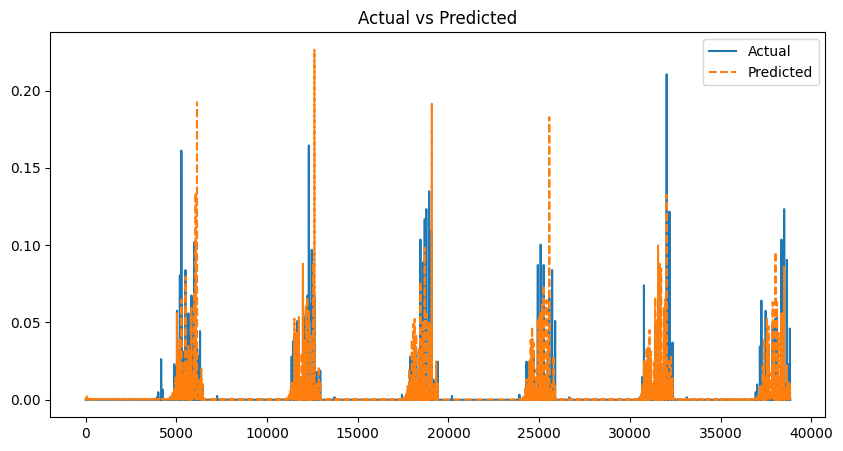

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are in shape (2807, 90, 250, 1)
y_pred = model.predict(X_test[:1])

# Reshape y_test and y_pred to (2807, 90 * 250)
y_test_flat = y_test[:1].reshape(-1)
y_pred_flat = y_pred.reshape(-1)

# Plot the actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_flat, label="Actual")
plt.plot(y_pred_flat, label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Actual vs Predicted")
plt.show()
